# German Credit Risk Classification

<sub>
This notebook walks through the complete workflow for building and evaluating classification models on the German Credit dataset.

## Table of Contents

### 📊 Data Preparation and Exploratory Analysis
1. Setup & Imports
2. Load Data & Rename Columns
3. Descriptive Statistics
4. Class Balance
5. Numerical Distributions by Risk
6. Categorical Distributions by Risk
7. Correlation Heatmap
8. Normality Check (Q–Q Plots)
9. Boxplot: Loan Amount by Risk

### 🤖 Model Training, Evaluation, and Reporting
10. Train/Test Split
11. Feature Scaling
12. PCA Analysis
13. Addressing Class Imbalance
14. Classification Models <br>
&emsp;&emsp;• 14.1 Helper Functions  <br>
&emsp;&emsp;• 14.2 Train & Cross‑Validate  <br>
15. Performance Visualization
16. Exporting Results for Reporting <br>
&emsp;&emsp;• 16.1 Feature Importances (Random Forest)  <br>
&emsp;&emsp;• 16.2 Model Summary Table
17. Next Steps
</sub>

## Data Preparation and Exploratory Analysis


### 1. Setup & Imports
We first import the necessary libraries and set up the environment. We will use `pandas` for data manipulation, `numpy` for numerical operations, and `seaborn` and `matplotlib` for visualization. We will also use `scikit-learn` for machine learning tasks.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE, KMeansSMOTE

sns.set_theme(style="whitegrid")


### 2. Load Data & Rename Columns

First we load the raw data to see the original column names. We can see that the original data was mixed of both numeric, categorical, ordinal and also custom coded features. We will first load data and then use SQL to map the custom coded features to their actual values based on what is defined in the data provider documentation. We will also rename the columns to make them more readable using the mapping provided in the `col_mapping.json` file.


In [2]:
raw_data_path = "data/raw/german_credit.csv"

# Load raw data
df = pd.read_csv(raw_data_path)
# print(df.head())
df.head()

import dataframe_image as dfi
dfi.export(df.head(), "plots/raw_data_preview.png", table_conversion="chrome")

With the data exported, we can now load the processed CSV and rename the columns using the mapping provided in the `col_mapping.json` file. This will help us make the column names more readable and easier to work with.

In [4]:
import pandas as pd
import json

# Path to processed CSV and column map JSON
data_path = "data/processed/credit_features.csv"
map_path = "data/col_mapping.json"

# Load data
df = pd.read_csv(data_path)

# Load column name mapping
with open(map_path, 'r') as f:
    col_map = json.load(f)

# Apply new column names
df.rename(columns=col_map, inplace=True)

print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

# for col in df.columns:
#     print(f"{col}: {df[col].dtype}")


Loaded 1000 rows and 98 columns.


,Checking Account (Raw),Loan Duration (Months),Credit History (Raw),Purpose (Raw),Credit Amount (DM),Savings Account (Raw),Employment Since (Raw),Installment Rate (%),Personal Status & Sex (Raw),Other Debtors (Raw),...,Job: Unskilled (Resident),Job: Skilled Worker,Job: Management,Number_of_people_being_liable_to_provide_maintenance_for:1,Telephone Status,Telephone: No Telephone,Telephone: Telephone Registered,Foreign Worker,Foreign Worker (Yes),Foreign Worker (No)
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,0,1,0,1,yes_registered,0,1,yes,1,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,0,1,0,1,none,1,0,yes,1,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,1,0,0,2,none,1,0,yes,1,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,0,1,0,2,none,1,0,yes,1,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,0,1,0,2,none,1,0,yes,1,0


The current dataset has 1000 rows and 98 columns, with 21 of them being from the original dataset. The rest are derived features. The target variable is `Risk Label`, which indicates whether the credit risk is good (1) or bad (2). We will also create a new column `Target` to map these values to 1 and 0 for easier processing in machine learning tasks.

### 3. Descriptive Statistics
We now summarize the numerical and categorical features in the dataset. Since we do the one hot encoding already, we only need to check the numerical features.

In [5]:
# Numerical summary
from IPython.display import display
import dataframe_image as dfi

print("Numerical feature summary:")

excluded_cols = [
    'Number_of_existing_credits_at_this_bank:1',
    'Number_of_people_being_liable_to_provide_maintenance_for:1',
    'Present_residence_since:1'
]

# Drop columns only if they exist
cols_to_drop = [col for col in excluded_cols if col in df.columns]
df_cleaned = df.drop(columns=cols_to_drop)

# Apply describe and style once
styled_summary = df_cleaned.describe().T.style.format(precision=2).background_gradient(cmap='Blues')

display(styled_summary)

# Save the styled DataFrame as a PNG image
styled_summary = df_cleaned.describe().T.style.format(precision=2).background_gradient(cmap='Blues')
dfi.export(styled_summary, "plots/numerical_summary.png", table_conversion='chrome')
print("✅ Saved styled numerical summary as PNG.")

# If you want to print the summary of the whole dataset, uncomment the next lines
# Categorical summary
# print("\nCategorical feature counts:")
# for col in df.select_dtypes(include='object').columns:
#     print(f"\n{col}:")
#     print(df[col].value_counts(dropna=False))


Numerical feature summary:


,count,mean,std,min,25%,50%,75%,max
Loan Duration (Months),1000.00,20.90,12.06,4.00,12.00,18.00,24.00,72.00
Credit Amount (DM),1000.00,3271.26,2822.74,250.00,1365.50,2319.50,3972.25,18424.00
Installment Rate (%),1000.00,2.97,1.12,1.00,2.00,3.00,4.00,4.00
Years at Residence,1000.00,2.85,1.10,1.00,2.00,3.00,4.00,4.00
Age (Years),1000.00,35.55,11.38,19.00,27.00,33.00,42.00,75.00
# Existing Credits,1000.00,1.41,0.58,1.00,1.00,1.00,2.00,4.00
Dependents,1000.00,1.16,0.36,1.00,1.00,1.00,1.00,2.00
Risk Label,1000.00,1.30,0.46,1.00,1.00,1.00,2.00,2.00
Credit per Month,1000.00,167.69,153.49,24.06,89.60,130.33,206.18,2482.67
Age < 25,1000.00,0.15,0.36,0.00,0.00,0.00,0.00,1.00


✅ Saved styled numerical summary as PNG.


### 4. Class Balance

In this part, we explore the class balance of the target variable `Risk Label` by visualizing the distribution of good and bad credit risks. We will use both a count plot and a pie chart to show the distribution of the target variable. The count plot will show the number of instances for each class, while the pie chart will show the percentage of each class in the dataset.

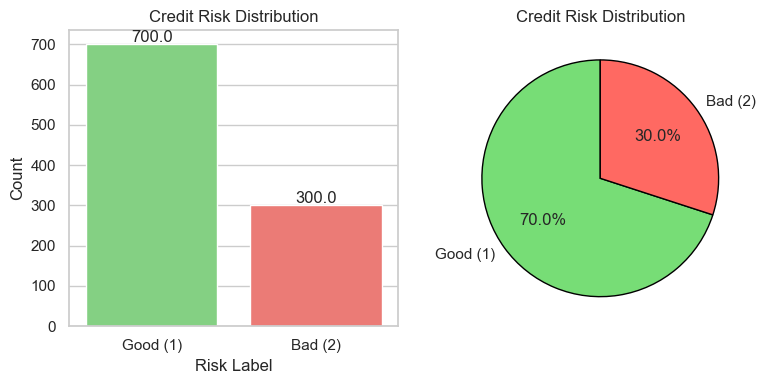

In [6]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Count plot
ax = sns.countplot(
    x='Risk Label', hue='Risk Label', data=df,
    palette=['#77DD76', '#FF6962'], legend=False, ax=axes[0]
)
ax.set_xticks([0, 1])  # Set tick positions
ax.set_xticklabels(['Good (1)', 'Bad (2)'])  # Set tick labels
ax.set_title('Credit Risk Distribution')
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + 5,
        p.get_height(),
        ha='center'
    )
ax.set_ylabel('Count')
ax.set_xlabel('Risk Label')

# Pie chart
risk_counts = df['Risk Label'].value_counts()
labels = ['Good (1)', 'Bad (2)']
colors = ['#77DD76', '#FF6962']
axes[1].pie(
    risk_counts, labels=labels, autopct='%1.1f%%',
    startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}
)
axes[1].set_title('Credit Risk Distribution')

# Adjust layout
plt.tight_layout()
#plt.savefig("plots/credit_eda.svg")
plt.show()

We can see that the dataset is quite imblanaced since among 1000 samples, only 300 or 30% of them are classified as bad credit risks. This is a common issue in credit risk datasets, and we will need to address this in the preprocessing steps. Overlooking this would lead to the classification model being biased towards the majority class, which is good credit risk in this case. We will use techniques like SMOTE or KMeansSMOTE to oversample the minority class or undersample the majority class to balance the dataset.


### 5. Numerical Distributions by Risk

Now, we will visualize the distributions of selected numerical features by risk label. We will use kernel density estimation (KDE) plots to show the distribution of `Credit Amount`, `Loan Duration`, and `Age` for both good and bad credit risks.


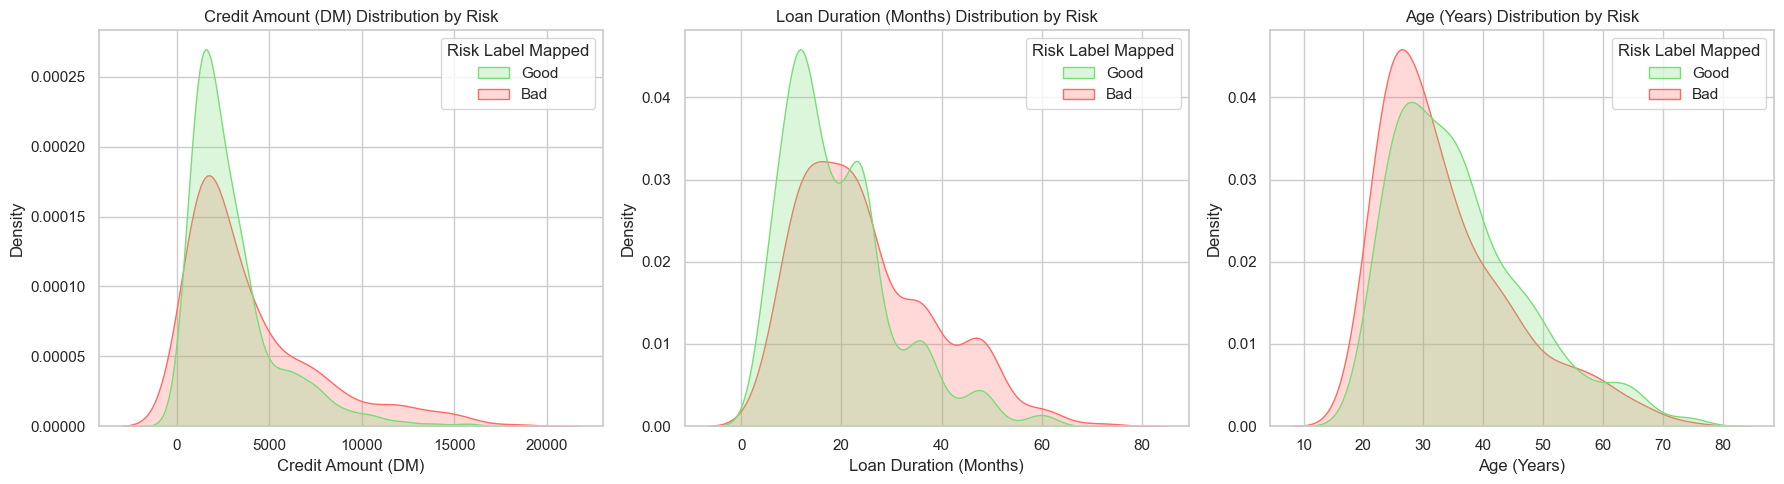

In [7]:
df['Risk Label Mapped'] = df['Risk Label'].map({1: 'Good', 2: 'Bad'})
# # Check unique values in the 'Risk Label' column
# print("Unique values in 'Risk Label':", df['Risk Label'].unique())
#
# # Check the value counts in the 'Risk Label' column
# print("Value counts in 'Risk Label':")
# print(df['Risk Label'].value_counts())

num_feats = ['Credit Amount (DM)', 'Loan Duration (Months)', 'Age (Years)']

# Create a single row of subplots
fig, axes = plt.subplots(1, len(num_feats), figsize=(18, 5), sharey=False)

for ax, feat in zip(axes, num_feats):
    sns.kdeplot(
        data=df, x=feat, hue='Risk Label Mapped',
        fill=True, common_norm=False,
        palette=['#77DD76', '#FF6962'], ax=ax
    )
    ax.set_title(f"{feat} Distribution by Risk")
    ax.set_xlabel(feat)
    ax.set_ylabel('Density')

plt.tight_layout()
plots_path = "plots/numerical_distribution.svg"
#plt.savefig(plots_path)
plt.show()


- **Credit Amount**: The distribution of the credit amount shows that bad credit risks tend have a wider range of credit amounts, with a peak around 20000 DM. Both of them, however, have the highest density around 2500 DM.
- **Loan Duration**: The loan duration distribution shows that bad credit risks tend to skewed towards longer loan durations, while good credit risks are more concentrated around shorter durations. This suggests that bad credit risks may be associated with longer loan terms and this should be focused more when building the classification model.
- **Age**: The age distributions nearly overlap, but bad credit risks tend to be slightly younger. This suggests that age alone is not a strong separator between good and bad credit risks, but it may still play a role in conjunction with other features.


### 6. Categorical Distributions by Risk

Count plots for selected categorical features.



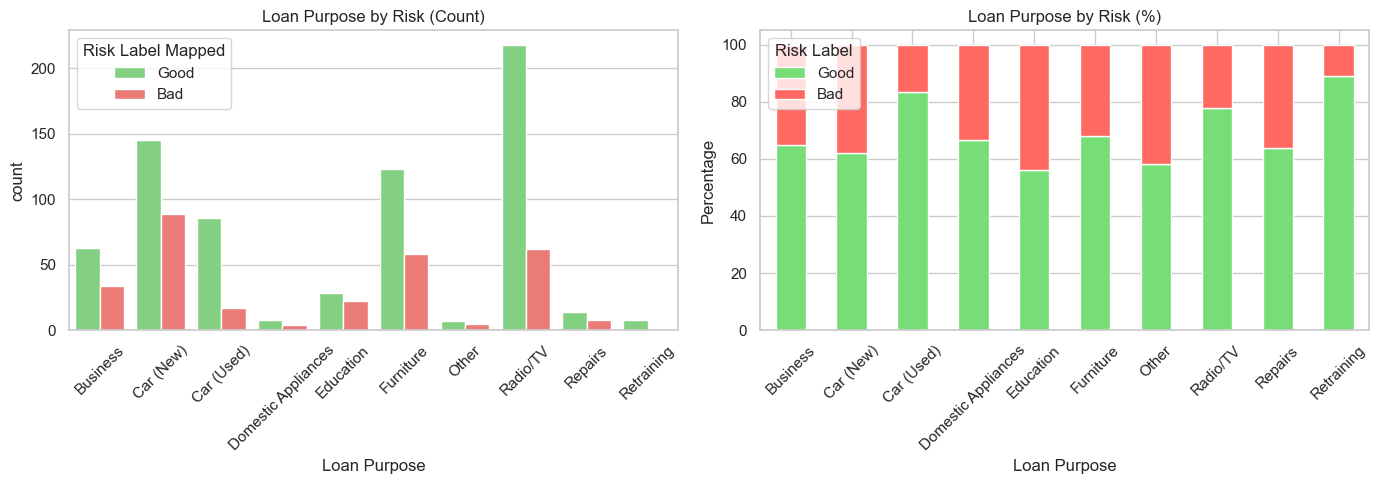

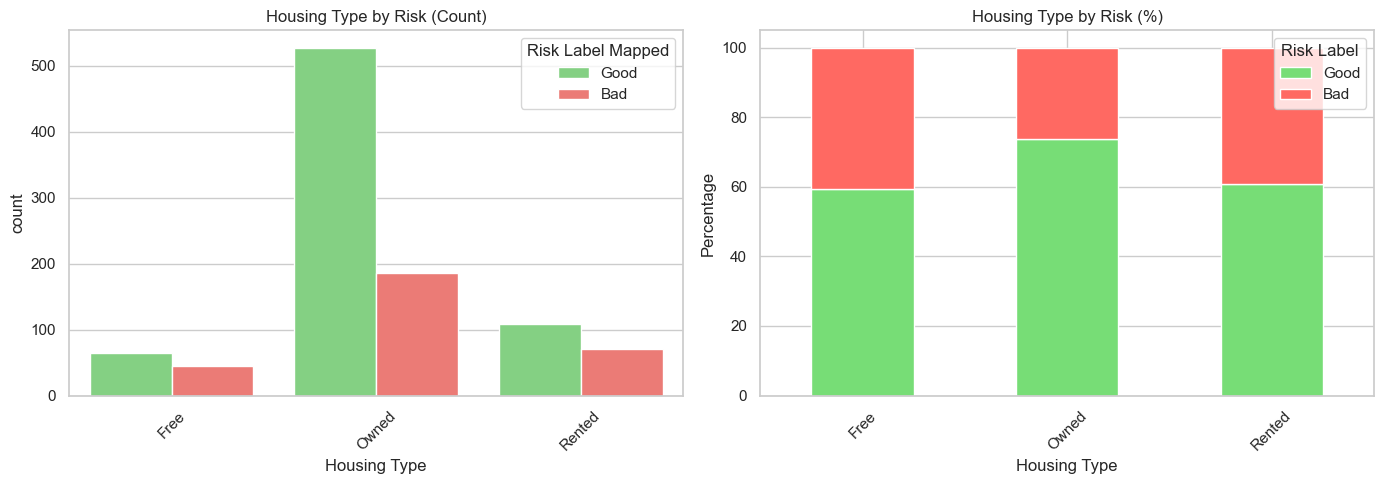

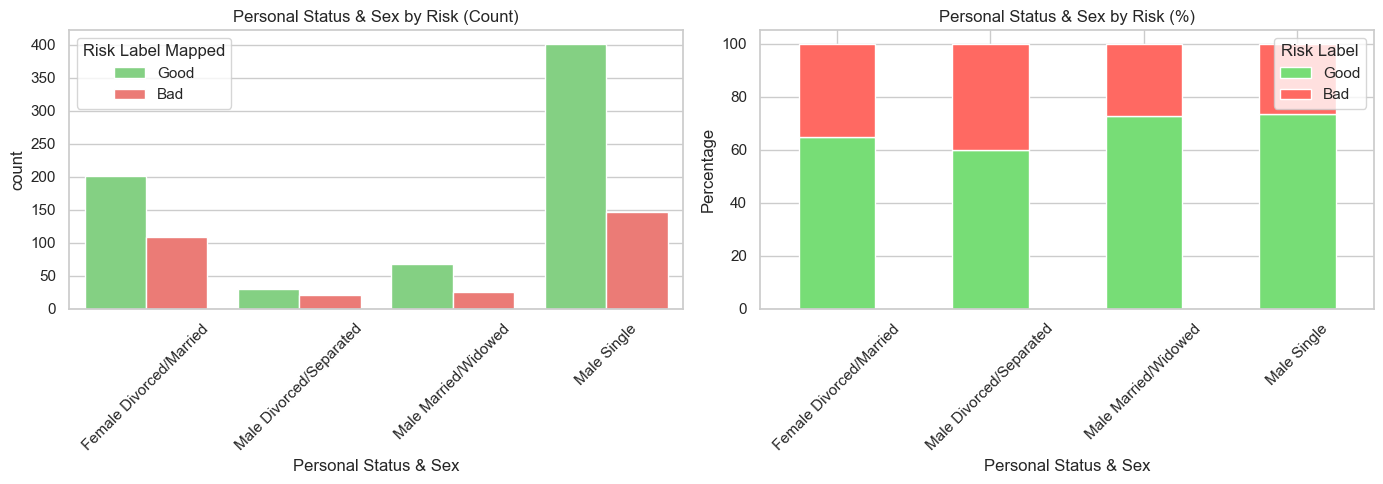

In [8]:
# Map for value translations on final column names
value_maps = {
    'Loan Purpose': {
        'car_new': 'Car (New)',
        'car_used': 'Car (Used)',
        'furniture': 'Furniture',
        'radio_tv': 'Radio/TV',
        'domestic_app': 'Domestic Appliances',
        'repairs': 'Repairs',
        'education': 'Education',
        'vacation': 'Vacation',
        'retraining': 'Retraining',
        'business': 'Business',
        'others': 'Other'
    },
    'Housing Type': {
        'rent': 'Rented',
        'own': 'Owned',
        'free': 'Free'
    },
    'Personal Status & Sex': {
        'm_div_sep': 'Male Divorced/Separated',
        'f_div_sep_mar': 'Female Divorced/Married',
        'm_single': 'Male Single',
        'm_mar_wid': 'Male Married/Widowed',
        'f_single': 'Female Single'
    }
}

# Now you don’t need display_to_actual anymore!
cat_feats = ['Loan Purpose', 'Housing Type', 'Personal Status & Sex']

for col in cat_feats:
    df_plot = df.copy()

    # Map column values if applicable
    if col in value_maps:
        df_plot[col] = df_plot[col].map(value_maps[col])

    # Define a consistent category order
    category_order = df_plot[col].value_counts().sort_index().index.tolist()

    # Compute percentage-based DataFrame
    crosstab = pd.crosstab(df_plot[col], df_plot['Risk Label Mapped'], normalize='index') * 100
    crosstab = crosstab[['Good', 'Bad']]  # Ensure correct column order
    crosstab = crosstab.reindex(category_order)  # Reindex rows to match category order

    # Create side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Raw count plot
    sns.countplot(
        data=df_plot, x=col, hue='Risk Label Mapped',
        palette=['#77DD76', '#FF6962'],
        order=category_order,
        ax=axes[0]
    )
    axes[0].set_title(f"{col} by Risk (Count)")
    axes[0].tick_params(axis='x', rotation=45)

    # Percentage plot
    crosstab.plot(
        kind='bar', stacked=True,
        color=['#77DD76', '#FF6962'],
        ax=axes[1]
    )
    axes[1].set_title(f"{col} by Risk (%)")
    axes[1].set_ylabel("Percentage")
    axes[1].legend(title='Risk Label')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plots_path = f"plots/categorical_distribution_{col}.svg"
    #plt.savefig(plots_path)
    plt.show()

- **Loan Purpose**: Radio/TV dominate in the good credit risk category, while the bad credit risk category is more evenly distributed across all purposes. If we look at the right plot, we can see that the ratio of good to bad credit risks is similar for all purposes except for Car (Used) and Retraining, which have a lower percentage of bad credit risks.
- **Housing Type**: The distribution shows that most people in the dataset own their homes and not many are renting or living for free. The percentage of bad credit risks is higher among those who are renting or living for free, which makes sense since these groups may have less financial stability. All of them have a similar ratio of good to bad credit risks with the home ownership group having the lowest percentage of bad credit risks.
- **Personal Status & Sex:** Male and female default rates are similar when normalized, but raw counts are higher for males due to their majority in the dataset.



### 7. Correlation Heatmap

One-hot encode categoricals and plot correlations.



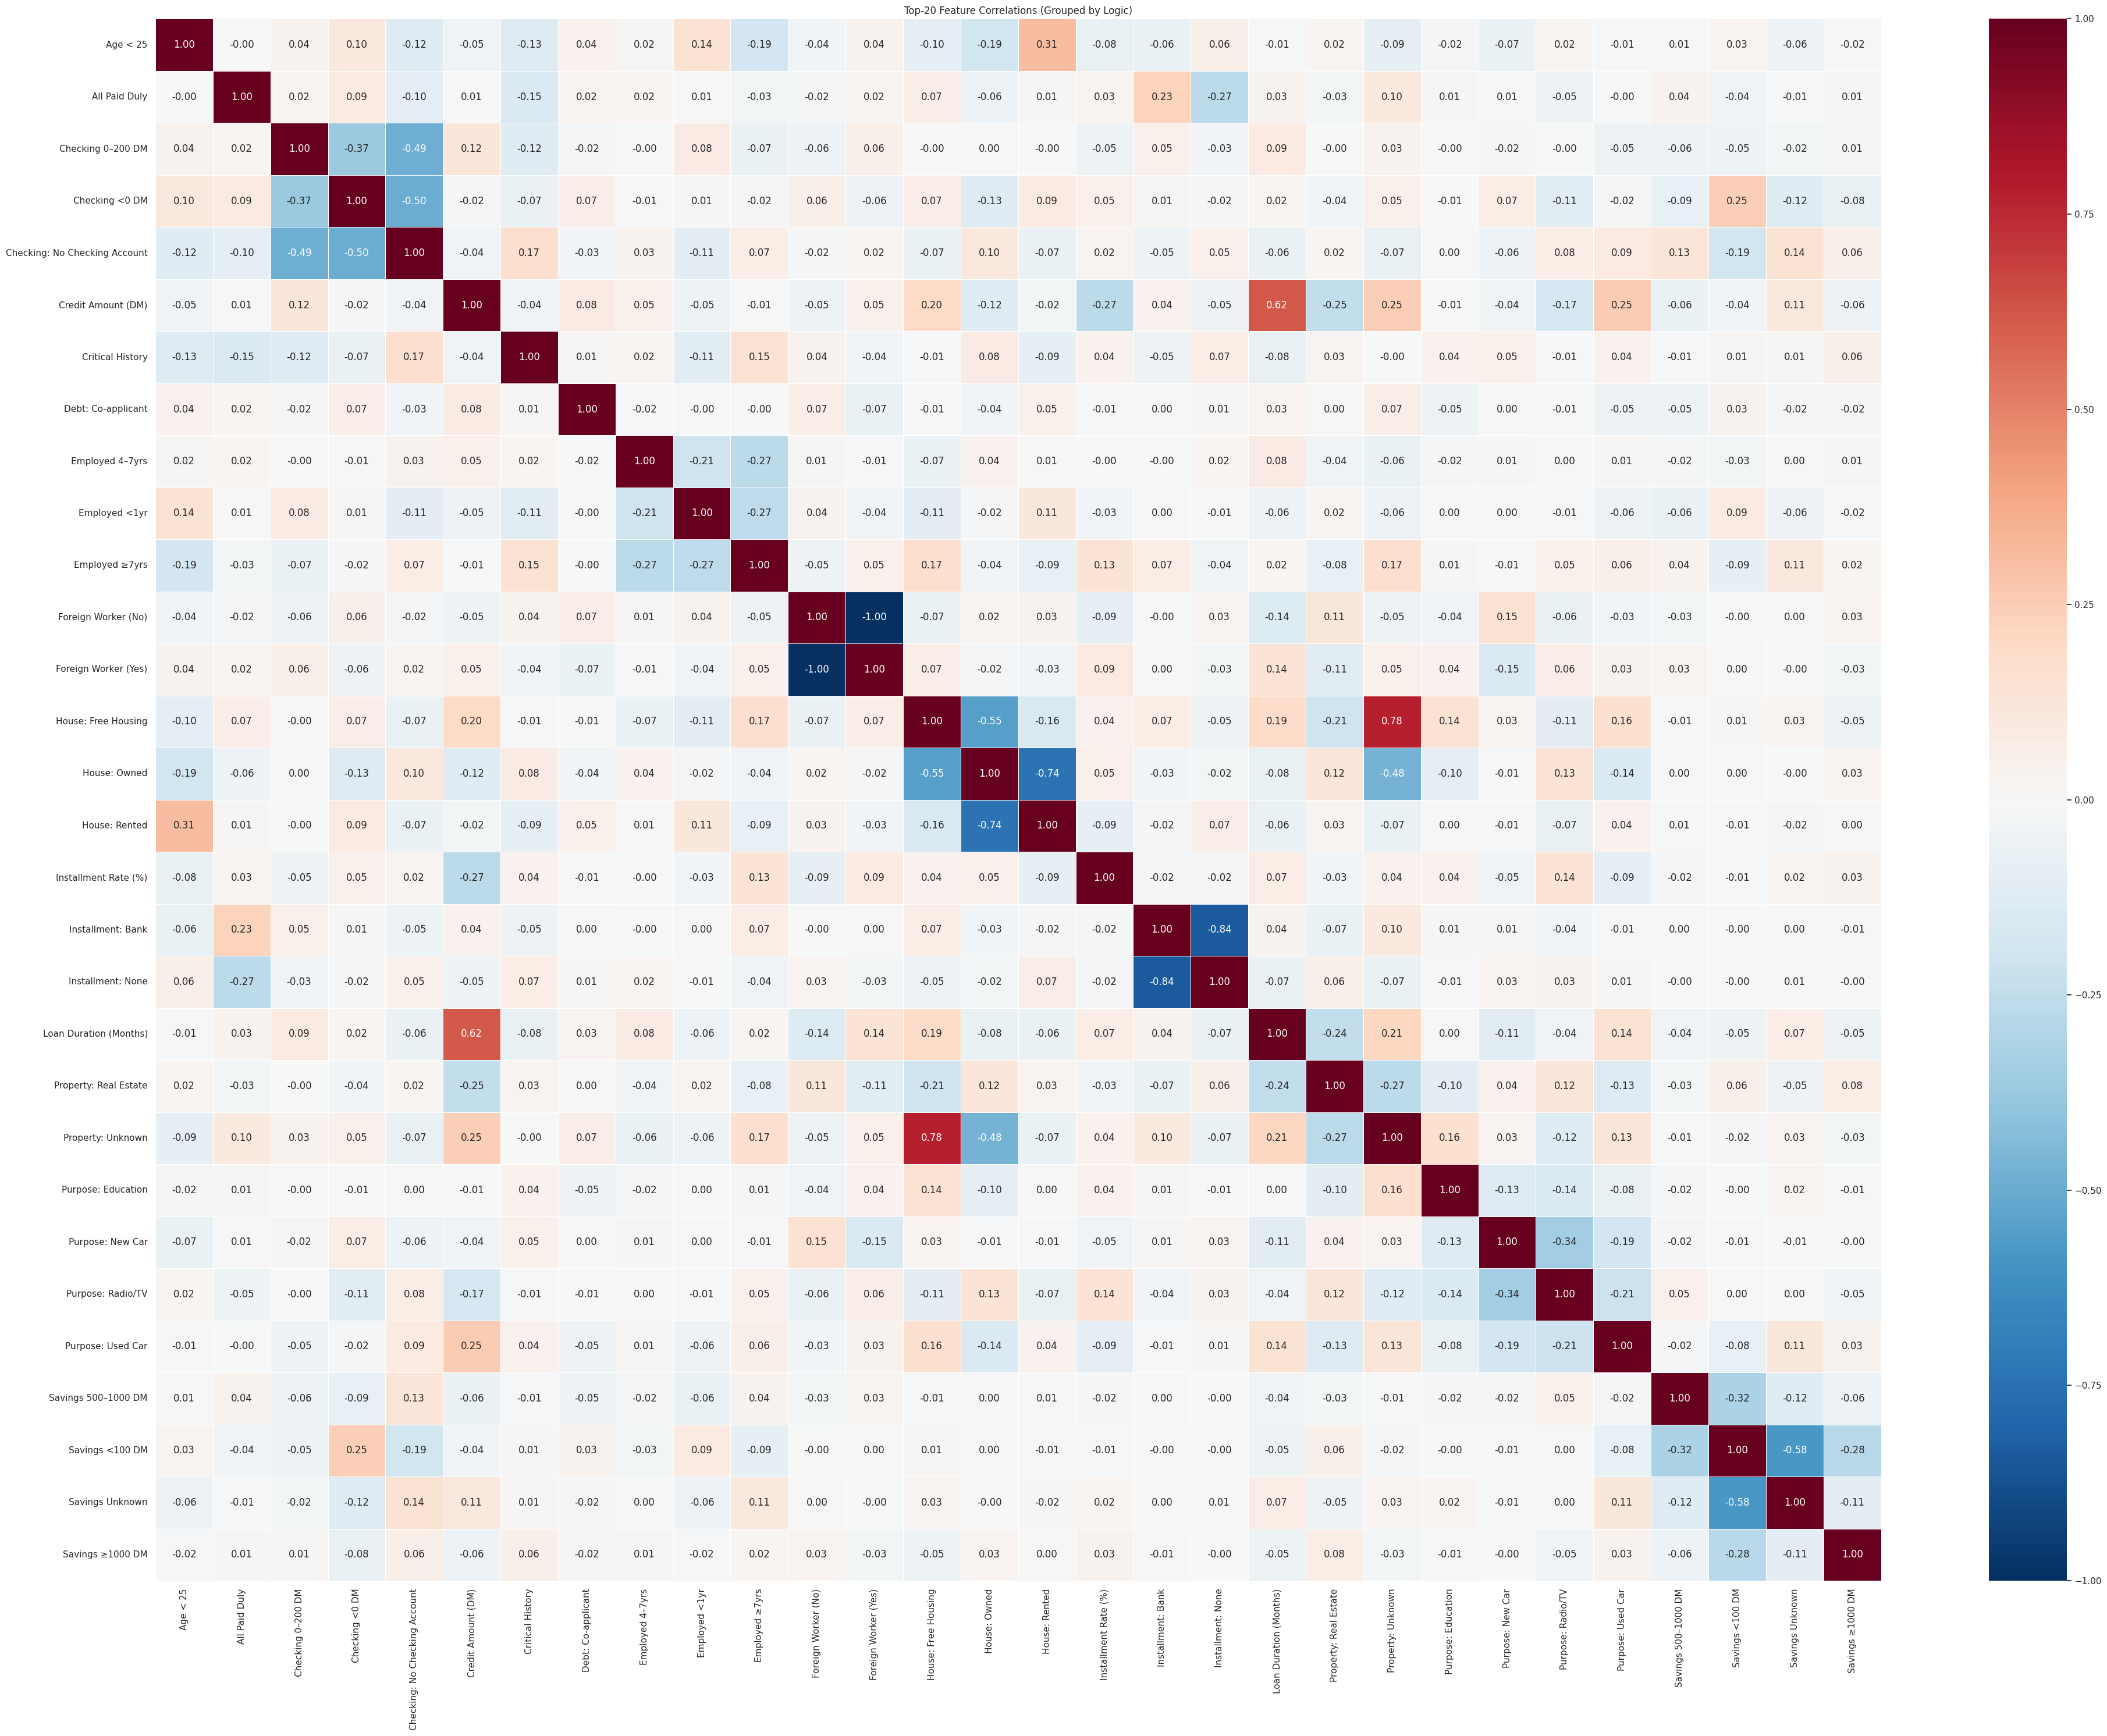

In [9]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict

# Create target column
df['Target'] = df['Risk Label'].map({1: 1, 2: 0})

# Encode categorical features
enc = pd.get_dummies(df.drop(columns=['Risk Label', 'Target']), drop_first=True)
enc['Target'] = df['Target']

# Remove specific one-hot encoded columns
cols_to_remove = [
    'Age (Years)',
    'No Credits',
    'Sex',
    'Male Divorced/Separated',
    'Female Divorced/Married',
    'Male Single',
]
enc.drop(columns=[col for col in cols_to_remove if col in enc.columns], inplace=True)
# Select only numeric columns
enc_numeric = enc.select_dtypes(include=['number'])

# 1. Mapping column to display name (as given)
col_display_names = {
    "chk_lt_0": "Checking <0 DM",
    "chk_0_200": "Checking 0–200 DM",
    "chk_ge_200": "Checking ≥200 DM",
    "chk_none": "No Checking Account",
    "hist_no_credits": "No Credits",
    "hist_all_paid": "All Paid Duly",
    "hist_existing_paid": "Existing Paid Duly",
    "hist_past_delay": "Past Delay",
    "hist_critical": "Critical History",
    "pur_car_new": "Purpose: New Car",
    "pur_car_used": "Purpose: Used Car",
    "pur_furniture": "Purpose: Furniture",
    "pur_radio_tv": "Purpose: Radio/TV",
    "pur_domestic": "Purpose: Domestic Appliances",
    "pur_repairs": "Purpose: Repairs",
    "pur_education": "Purpose: Education",
    "pur_vacation": "Purpose: Vacation",
    "pur_retraining": "Purpose: Retraining",
    "pur_business": "Purpose: Business",
    "pur_others": "Purpose: Others",
    "sav_lt_100": "Savings <100 DM",
    "sav_100_500": "Savings 100–500 DM",
    "sav_500_1000": "Savings 500–1000 DM",
    "sav_ge_1000": "Savings ≥1000 DM",
    "sav_unknown": "Savings Unknown",
    "emp_unempl": "Unemployed",
    "emp_lt1": "Employed <1yr",
    "emp_1_4": "Employed 1–4yrs",
    "emp_4_7": "Employed 4–7yrs",
    "emp_ge7": "Employed ≥7yrs",
    "sex_m_divsep": "Male Divorced/Separated",
    "sex_f_divsep_mar": "Female Divorced/Married",
    "sex_m_single": "Male Single",
    "sex_m_marwid": "Male Married/Widowed",
    "sex_f_single": "Female Single",
    "debt_none": "No Debtors",
    "debt_coapp": "Co-applicant",
    "debt_guarantor": "Guarantor",
    "prop_real": "Property: Real Estate",
    "prop_sav_ins": "Property: Savings Insurance",
    "prop_car_other": "Property: Car/Other",
    "prop_unknown": "Property: Unknown",
    "inst_bank": "Installment: Bank",
    "inst_stores": "Installment: Stores",
    "inst_none": "Installment: None",
    "house_rent": "Rented",
    "house_own": "Owned",
    "house_free": "Free Housing",
    "job_unsk_nonres": "Unskilled (Non-resident)",
    "job_unsk_res": "Unskilled (Resident)",
    "job_skilled": "Skilled Worker",
    "job_manage": "Management",
    "tel_none": "No Telephone",
    "tel_yes": "Telephone Registered",
    "foreign_yes": "Foreign Worker (Yes)",
    "foreign_no": "Foreign Worker (No)"
}

# 2. Manually assign group names (you can reorder these)
group_keywords = {
    'Checking': ['chk_'],
    'Credit History': ['hist_'],
    'Purpose': ['pur_'],
    'Savings': ['sav_'],
    'Employment': ['emp_'],
    'Sex': ['Personal Status & Sex'],
    'Debtors': ['debt_'],
    'Property': ['prop_'],
    'Installment Plans': ['inst_'],
    'Housing': ['house_'],
    'Job': ['job_'],
    'Telephone': ['tel_'],
    'Foreign Worker': ['foreign_'],
}

# Explicit fallback for misclassified features
explicit_group_map = {
    'chk_none': 'Checking',
    'chk_lt_0': 'Checking',
    'chk_0_200': 'Checking',
    'chk_ge_200': 'Checking',
}

# 3. Reverse-assign groups with fallback
grouped_cols = defaultdict(list)

for col in enc.columns:
    if col == "Target":
        continue

    # First check explicit mapping
    if col in explicit_group_map:
        grouped_cols[explicit_group_map[col]].append(col)
        continue

    # Match by any prefix in group_keywords
    assigned = False
    for group, prefixes in group_keywords.items():
        for prefix in prefixes:
            if col.startswith(prefix):  # more robust for multiple prefixes
                grouped_cols[group].append(col)
                assigned = True
                break
        if assigned:
            break

    if not assigned:
        grouped_cols["Other"].append(col)

# 4. Sort columns by group order
group_order = list(group_keywords.keys()) + ['Other']
ordered_columns = []
for group in group_order:
    ordered_columns.extend(sorted(grouped_cols[group]))

# 5. Filter numeric and reorder
enc_numeric_ordered = enc[ordered_columns + ['Target']].select_dtypes(include='number')

# 6. Pick top 20 by absolute correlation to Target, but preserve group order
corr_to_target = enc_numeric_ordered.corr()['Target'].abs().sort_values(ascending=False).index[1:31]
top20_cols = [col for col in ordered_columns if col in corr_to_target]

# 7. Plot heatmap using ordered top 20
sub = enc_numeric_ordered[top20_cols]

rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(40, 30))
sns.heatmap(
    sub.corr(), cmap='RdBu_r', center=0,
    annot=True, fmt=".2f", linewidths=0.5,
    xticklabels=sub.columns, yticklabels=sub.columns
)
plt.title("Top‑20 Feature Correlations (Grouped by Logic)")
plt.tight_layout()
plots_path = "plots/corrlation_heatmaps.svg"
#plt.savefig(plots_path)
plt.show()

# print([col for col in enc.columns if 'sex' in col.lower()])

# # Debug print to verify which columns were grouped
# for group, cols in grouped_cols.items():
#     print(f"\nGroup: {group} ({len(cols)} features)")
#     for col in cols:
#         print(f"  - {col}")

Most of the features are more correlated when they come from the same group. Since all the same group features are one-hot encoded, this is expected and can be seen in the heat map as the square with stronger color. The features also do not have much correlation with other features, which is good since we want to avoid multicollinearity.

### 8. Normality Check (Q–Q Plots)
Now, we use Q-Q plots to see whether the three key numerical features follow a normal distribution.


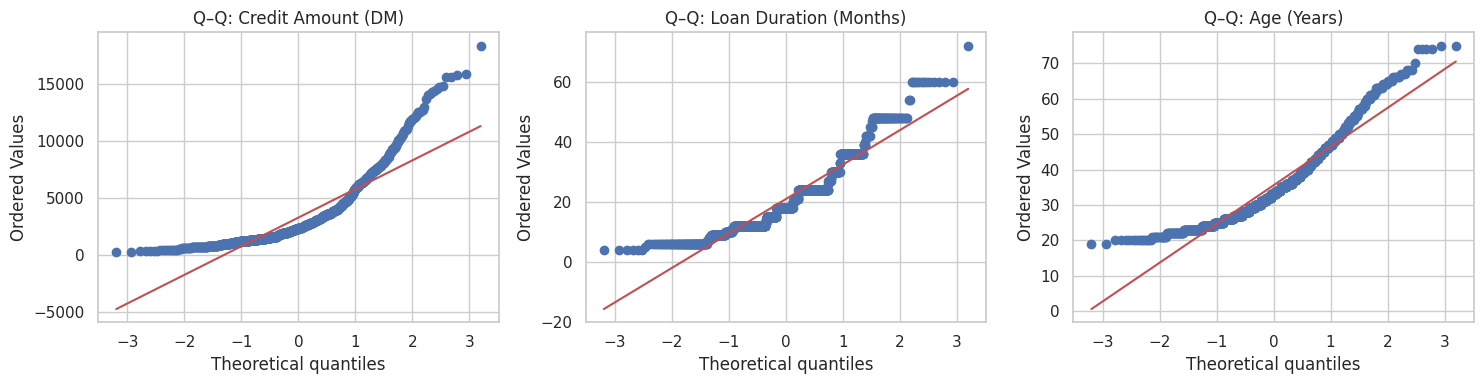

In [10]:
num_feats = ['Credit Amount (DM)', 'Loan Duration (Months)', 'Age (Years)']
fig, axes = plt.subplots(1, len(num_feats), figsize=(5*len(num_feats), 4))
for ax, feat in zip(axes, num_feats):
    stats.probplot(df[feat], dist='norm', plot=ax)
    ax.set_title(f"Q–Q: {feat}")
plt.tight_layout()
plots_path = "plots/qq_plots.svg"
#plt.savefig(plots_path)
plt.show()


- **Credit Amount:** Points deviate markedly in the tails—heavy right‐skew, not Normal.
- **Loan Duration & Age:** Also depart from the line, though less extremely.


### 9. Boxplot: Loan Amount by Risk
Now, we use box plots to compare the distribution of key numerical features across credit risk groups.



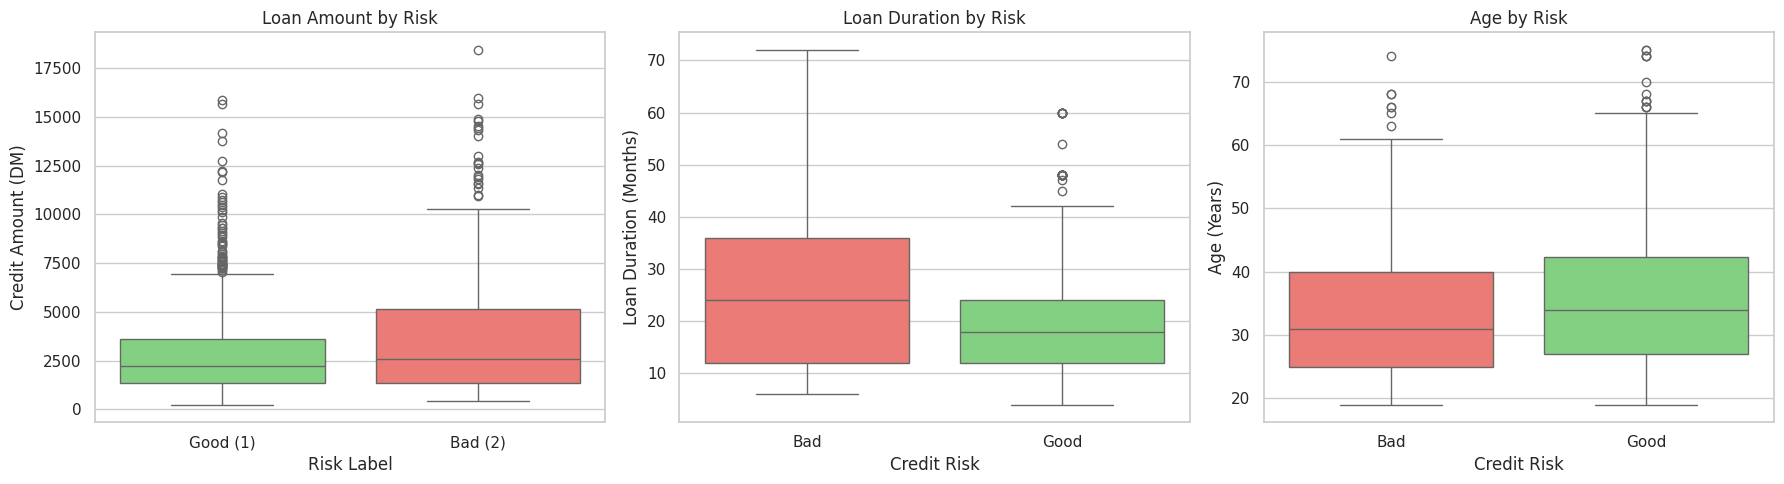

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Boxplot 1: Credit Amount
sns.boxplot(
    x='Risk Label', y='Credit Amount (DM)', hue='Risk Label',
    data=df, palette=['#77DD76', '#FF6962'], dodge=False, ax=axes[0]
)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Good (1)', 'Bad (2)'])
axes[0].set_title('Loan Amount by Risk')
axes[0].legend_.remove()  # Remove legend from first plot

# Boxplot 2: Loan Duration
sns.boxplot(
    x='Target', y='Loan Duration (Months)', hue='Target',
    data=df, palette=['#FF6962', '#77DD76'], ax=axes[1]
)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Bad', 'Good'])
axes[1].set_title('Loan Duration by Risk')
axes[1].set_xlabel('Credit Risk')
axes[1].set_ylabel('Loan Duration (Months)')
axes[1].legend_.remove()

# Boxplot 3: Age
sns.boxplot(
    x='Target', y='Age (Years)', hue='Target',
    data=df, palette=['#FF6962', '#77DD76'], ax=axes[2]
)
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Bad', 'Good'])
axes[2].set_title('Age by Risk')
axes[2].set_xlabel('Credit Risk')
axes[2].set_ylabel('Age (Years)')
axes[2].legend_.remove()

plt.tight_layout()
plots_path = "plots/box_plots.svg"
#plt.savefig(plots_path)
plt.show()

- **Credit Amount:** Median bad‐risk amount (~ DM 4 000) exceeds good‐risk (~ DM 2 200), with many high‐value outliers among defaults.
- **Loan Duration:** Bad loans show both higher median and longer whiskers—longer obligations carry more risk.
- **Age:** Very similar medians and spreads—age is not a primary risk driver here.

# Model Training, Evaluation, and Reporting


### 10. Train/Test Split
Now, we split the dataset into training and test sets using stratified sampling to preserve the class distribution of the target variable.

We perform some cleaning before proceeding to the next part.


In [12]:
# Fill NA values with 'Unknown' for certain categorical features
cat_fill_cols = [
    'Checking Account Status', 'Savings Account',
    'Credit History', 'Loan Purpose', 'Housing Type',
    'Employment Length', 'Other Debtors', 'Property Type',
    'Installment Plans', 'Telephone Status', 'Foreign Worker',
    'Personal Status & Sex'
]
for col in cat_fill_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# Binary encode 'Sex' from 'Personal Status & Sex'
# df['Sex'] = df['Personal Status & Sex'].apply(lambda x: 'male' in x.lower()).astype(int)
df['Sex'] = df['Personal Status & Sex'].apply(lambda x: 1 if x[0].lower() == 'm' else 0)


# Encode target: 1 = Good, 0 = Bad
df['Target'] = df['Risk Label'].map({1: 1, 2: 0})

# # One-hot encode all nominal/ordinal categoricals (except Risk Label and original codes)
df_encoded = pd.get_dummies(
    # df.drop(columns=['Risk Label', 'Personal Status & Sex']),
    df,
    drop_first=True
)

print(f"Encoded dataset shape: {df_encoded.shape}")

#

Encoded dataset shape: (1000, 158)


In [13]:
from sklearn.model_selection import train_test_split

# Split into features and target
X = df_encoded.drop(columns=['Target'])
y = df_encoded['Target']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print('Train class counts:', y_train.value_counts().to_dict())
print('Test class counts :', y_test.value_counts().to_dict())

Train class counts: {1: 560, 0: 240}
Test class counts : {1: 140, 0: 60}


### 11. Feature Scaling
Next, to improve the performance and stability of machine learning models, we scale the features using two common techniques: standardization (zero mean, unit variance) and min-max scaling (0–1 range). This helps ensure that all features contribute equally during training.



In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardization (mean=0, std=1) on full feature set
std_scaler = StandardScaler()
X_train_std = pd.DataFrame(std_scaler.fit_transform(X_train), columns=X_train.columns)
X_test_std  = pd.DataFrame(std_scaler.transform(X_test), columns=X_test.columns)

# Min-Max Scaling (0–1) as alternative
mm_scaler = MinMaxScaler()
X_train_mm = pd.DataFrame(mm_scaler.fit_transform(X_train), columns=X_train.columns)
X_test_mm  = pd.DataFrame(mm_scaler.transform(X_test), columns=X_test.columns)

print("Standardization and Min-Max scaling complete.")

Standardization and Min-Max scaling complete.


### 12. PCA Analysis
To reduce dimensionality while preserving most of the dataset’s variance, we apply Principal Component Analysis (PCA) on the standardized features. A scree plot helps identify the number of components needed to explain at least 95% of the variance. The final transformed data is then used for further analysis, and a 2D projection offers a visual insight into class separation.


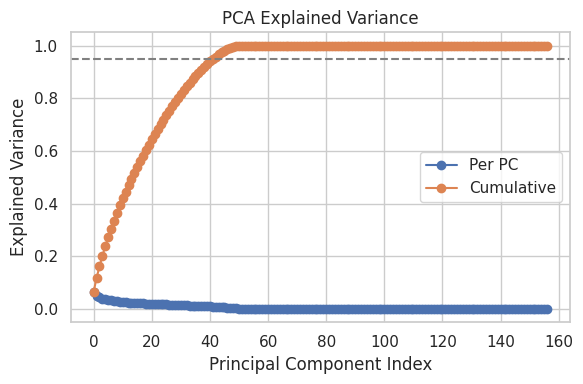

Number of PCs explaining ≥95% variance: 43
PCA transformation complete.


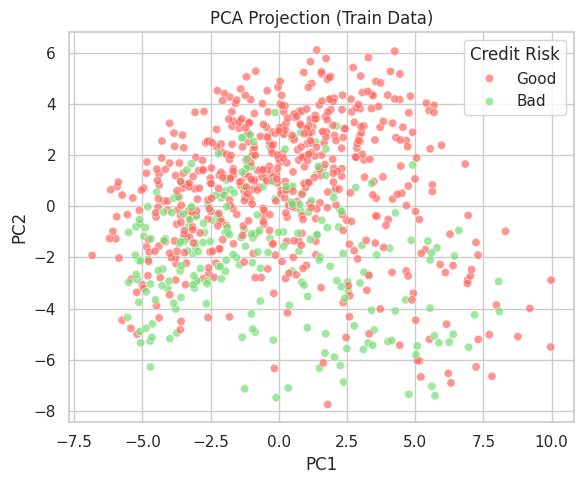

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA on standardized full feature set
pca_temp = PCA()
X_pca_temp = pca_temp.fit_transform(X_train_std)
explained = pca_temp.explained_variance_ratio_

# Cumulative variance with strict monotonicity fix
cumvar = np.cumsum(explained)
epsilon = 1e-10
cumvar_strict = cumvar + epsilon * np.arange(len(cumvar))
cumvar_unique, idx_unique = np.unique(cumvar_strict, return_index=True)
explained_unique = explained[idx_unique]

# Scree plot
plt.figure(figsize=(6,4))
plt.plot(explained_unique, marker='o', label='Per PC')
plt.plot(cumvar_unique, marker='o', label='Cumulative')
plt.axhline(0.95, linestyle='--', color='gray')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.tight_layout()
plots_path = "plots/pca_explained_variance.svg"
#plt.savefig(plots_path)
plt.show()

# Select number of components for 95% variance
n_components = np.argmax(cumvar_unique >= 0.95) + 1
print(f"Number of PCs explaining ≥95% variance: {n_components}")

# Final PCA transformation
pca_final = PCA(n_components=n_components)
X_train_pca = pca_final.fit_transform(X_train_std)
X_test_pca  = pca_final.transform(X_test_std)
print('PCA transformation complete.')

# Optional 2D Projection for visualization
pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train_std)

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=X_train_2d[:, 0], y=X_train_2d[:, 1],
    hue=y_train.map({1: 'Good', 0: 'Bad'}),
    palette=['#FF6962', '#77DD76'], alpha=0.7
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection (Train Data)')
plt.legend(title='Credit Risk')
plt.tight_layout()
plots_path = "plots/pca_explained_variance_2d.svg"
#plt.savefig(plots_path)
plt.show()

### 13. Addressing Class Imbalance
To further improve model performance on imbalanced data, we apply several resampling techniques: Cluster Centroids (undersampling), SMOTE, and KMeans-SMOTE (oversampling). These methods help balance the class distribution, and their effects are visualized through bar plots.


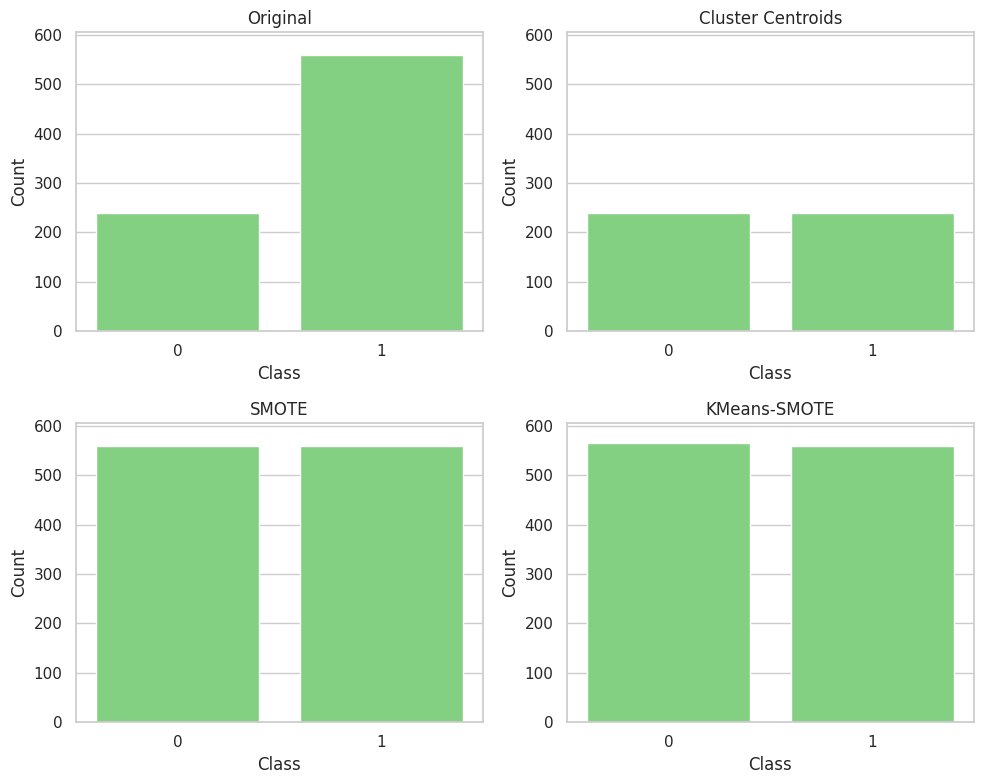

In [16]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()  # Flatten for easy indexing

def plot_counts(ax, y, title):
    cnt = Counter(y)
    sns.barplot(x=list(cnt.keys()), y=list(cnt.values()), color="#77DD76", ax=ax)
    ax.set_ylim(0, 550 * 1.1)
    ax.set_title(title)
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')

# Original
target_train = y_train.copy()
plot_counts(axes[0], target_train, 'Original')

# Cluster Centroids
cc = ClusterCentroids(random_state=42)
X_cc, y_cc = cc.fit_resample(X_train_pca, target_train)
plot_counts(axes[1], y_cc, 'Cluster Centroids')

# SMOTE
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_train_pca, target_train)
plot_counts(axes[2], y_sm, 'SMOTE')

# KMeans-SMOTE using scaled full features instead of PCA
km = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.01)
X_ksm, y_ksm = km.fit_resample(X_train_std, target_train)
plot_counts(axes[3], y_ksm, 'KMeans-SMOTE')

plt.tight_layout()
plots_path = "plots/kmeans-smote.svg"
#plt.savefig(plots_path)
plt.show()

### 14. Classification Models

We’ll train three classifiers—Logistic Regression, SVM, and Random Forest—using stratified 5‑fold CV (optimizing F1-score). Then we’ll evaluate on the held‑out test set.

#### 14.1 Helper Functions

These routines streamline grid search, evaluation metrics, and plotting for all models in a consistent and organized manner.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, auc

# define models and parameter grids
models = {
    'LogisticRegression': {
        'est': LogisticRegression(max_iter=1000, random_state=42),
        'params': {'C': [0.01, 0.1, 1, 10]}
    },
    'RandomForest': {
        'est': RandomForestClassifier(random_state=42),
        'params': {'n_estimators': [50,100], 'max_depth': [None,10,20]}
    },
    'SVM': {
        'est': SVC(probability=True, random_state=42),
        'params': {'C': [0.1,1,10], 'kernel': ['rbf','linear']}
    }
}

#### 14.2 Train & Cross‑Validate
We train and evaluate each model using 5-fold cross-validated grid search, selecting the best hyperparameters based on F1 score. After training, we compute key performance metrics—F1, precision, recall, and PR-AUC—on the test set and store the results for comparison.

In [18]:
cv_results = {}

for name, m in models.items():
    print(f"\nTraining {name}...")
    grid = GridSearchCV(
        m['est'], m['params'],
        scoring='f1', cv=5, n_jobs=-1, verbose=0
    )
    grid.fit(X_train_pca, y_train)
    best = grid.best_estimator_
    y_pred = best.predict(X_test_pca)
    y_proba = best.predict_proba(X_test_pca)[:,1]

    # metrics
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall[::-1], precision[::-1])  # ensure increasing recall

    cv_results[name] = {
        'BestParams': grid.best_params_,
        'F1': f1, 'Precision': prec, 'Recall': rec, 'PR_AUC': pr_auc,
        'Estimator': best
    }
    print(f"  → Best Params: {grid.best_params_}")
    print(f"  → Test F1: {f1:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, PR‑AUC: {pr_auc:.3f}")


Training LogisticRegression...
  → Best Params: {'C': 0.1}
  → Test F1: 0.956, Precision: 0.978, Recall: 0.936, PR‑AUC: 0.993

Training RandomForest...
  → Best Params: {'max_depth': None, 'n_estimators': 100}
  → Test F1: 0.947, Precision: 0.937, Recall: 0.957, PR‑AUC: 0.988

Training SVM...
  → Best Params: {'C': 10, 'kernel': 'rbf'}
  → Test F1: 0.972, Precision: 0.965, Recall: 0.979, PR‑AUC: 0.997


### 15. Results Visualization

#### 15.1 F1 Comparison Bar Chart
Now, we compare the test F1 scores of all models using a bar plot to visualize their relative performance.


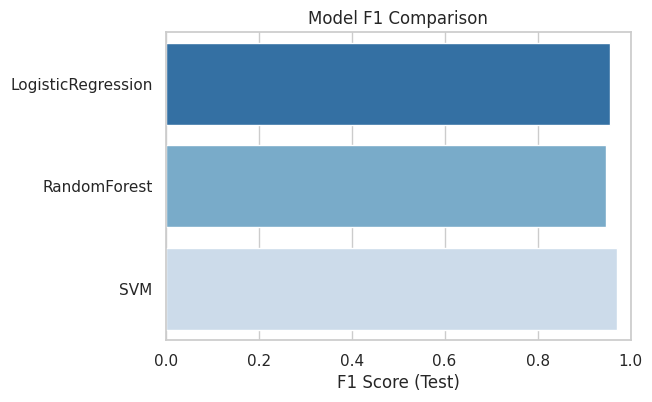

In [19]:
names = list(cv_results.keys())
scores = [cv_results[n]['F1'] for n in names]

plt.figure(figsize=(6,4))
sns.barplot(x=scores, y=names, hue=names, palette='Blues_r', dodge=False, legend=False)
plt.xlabel('F1 Score (Test)')
plt.title('Model F1 Comparison')
plt.xlim(0,1)
plots_path = "plots/f1-score.svg"
#plt.savefig(plots_path)
plt.show()

#### 15.2 Confusion Matrices & PR Curves
To gain deeper insights into each model’s performance, we visualize both the confusion matrix and the precision–recall curve. These plots highlight how well each model distinguishes between classes and performs under different classification thresholds.

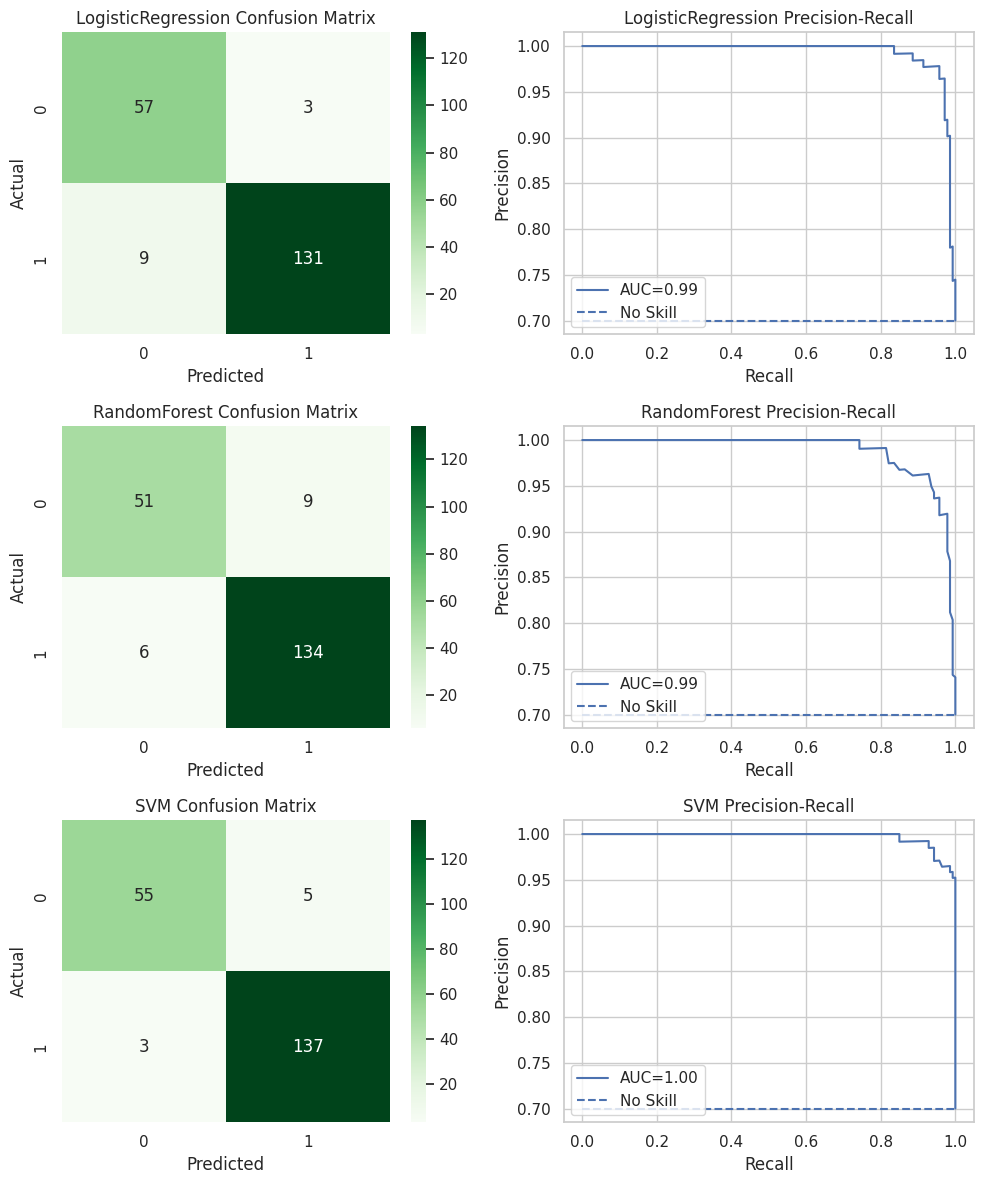

In [20]:
fig, axes = plt.subplots(len(models), 2, figsize=(10, 4*len(models)))
for i,(name, res) in enumerate(cv_results.items()):
    est = res['Estimator']
    # Confusion
    cm = confusion_matrix(y_test, est.predict(X_test_pca))
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i,0], cmap='Greens')
    axes[i,0].set_title(f'{name} Confusion Matrix')
    axes[i,0].set_xlabel('Predicted')
    axes[i,0].set_ylabel('Actual')
    # PR Curve
    prec, rec, _ = precision_recall_curve(y_test, est.predict_proba(X_test_pca)[:,1])
    axes[i,1].plot(rec, prec, label=f'AUC={res["PR_AUC"]:.2f}')
    axes[i,1].hlines(y=y_test.mean(), xmin=0, xmax=1, linestyles='--', label='No Skill')
    axes[i,1].set_title(f'{name} Precision-Recall')
    axes[i,1].set_xlabel('Recall')
    axes[i,1].set_ylabel('Precision')
    axes[i,1].legend()
plt.tight_layout()
plots_path = "plots/precision-recall.svg"
#plt.savefig(plots_path)
plt.show()

### 16. Export for BI / Reporting
To support downstream analysis and reporting, we export key artifacts including the Random Forest feature importances and a model summary table. These outputs can be easily integrated into business intelligence tools or documentation for further exploration.

#### 16.1 Feature Importances (Random Forest)
We extract and save the feature importances from the best-performing Random Forest model. These values indicate how much each principal component contributes to the model’s decisions.

In [21]:
# grab RF importances
rf = cv_results['RandomForest']['Estimator']
importances = pd.Series(rf.feature_importances_, index=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
importances.sort_values(ascending=False).to_csv('data/processed/rf_feature_importances.csv')
print("Saved RF feature importances to data/processed/rf_feature_importances.csv")

Saved RF feature importances to data/processed/rf_feature_importances.csv


#### 16.2 Model Summary Table
We compile a summary table of the best hyperparameters and key evaluation metrics (F1, precision, recall, PR-AUC) for each model and save it for easy comparison and reporting.

In [22]:
summary = pd.DataFrame(cv_results).T[['BestParams','F1','Precision','Recall','PR_AUC']]
summary.to_csv('data/processed/model_summary.csv')
print("Saved model summary to data/processed/model_summary.csv")
summary

Saved model summary to data/processed/model_summary.csv


,BestParams,F1,Precision,Recall,PR_AUC
LogisticRegression,{'C': 0.1},0.956204,0.977612,0.935714,0.992994
RandomForest,"{'max_depth': None, 'n_estimators': 100}",0.946996,0.937063,0.957143,0.988143
SVM,"{'C': 10, 'kernel': 'rbf'}",0.971631,0.964789,0.978571,0.997115


### 17. Next Steps

- Build dashboards in Tableau/Power BI using `model_summary.csv` and `rf_feature_importances.csv`.
- Consider ensembling or hyperparameter fine‑tuning for further gains.